# __New York Restaurant Analysis by Cuisine__

Import required libraires

In [2]:
import numpy as np # library to handle data in a vectorized manner
import pandas as pd # library for data analsysis
import matplotlib 
import matplotlib.pyplot as plt
import requests # library to handle requests
from pandas import json_normalize # tranform JSON file into a pandas dataframe
from bs4 import BeautifulSoup
import lxml
import math
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim
import folium
import json

Ready the client id, secret and version required for foursqaure api 

In [6]:
CLIENT_ID = '5SXQLEP4XW0YPT12WC03YKD4K1F01MUE1422BLADUNJP3FH2' # your Foursquare ID
CLIENT_SECRET = 'BAI5ARXH42QCA0CPFZI4Q3X4K1XIR1P13EFAFJV341KONLZN' # your Foursquare Secret
VERSION = '20180323' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: 5SXQLEP4XW0YPT12WC03YKD4K1F01MUE1422BLADUNJP3FH2
CLIENT_SECRET:BAI5ARXH42QCA0CPFZI4Q3X4K1XIR1P13EFAFJV341KONLZN


Fetch New York neighborhoods data

In [3]:
neighborhoods = requests.get('https://cocl.us/new_york_dataset').json()


In [4]:
# assign relevant part of JSON to areas
areas = neighborhoods['features']

# tranform areas into a dataframe
areas = json_normalize(areas)
df = pd.DataFrame(columns=["name","borough","lat","lon"])
for i in range(areas.shape[0]):
    df.at[i,["lon","lat"]] = areas['geometry.coordinates'][i]
df[["name","borough"]]=areas[['properties.name','properties.borough']]
df.head()


,name,borough,lat,lon
0,Wakefield,Bronx,40.8947,-73.8472
1,Co-op City,Bronx,40.8743,-73.8299
2,Eastchester,Bronx,40.8876,-73.8278
3,Fieldston,Bronx,40.8954,-73.9056
4,Riverdale,Bronx,40.8908,-73.9126


Fetch top 20 popular restaurants in each neighborhood using foursquare api

In [7]:
the_venues=[]

for name,borough,lat,lon in zip(df['name'],df['borough'],df['lat'],df['lon']):
    search_query = 'restaurant'
    radius = 1000
    LIMIT = 20
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, lat, lon, VERSION, search_query, radius, LIMIT)
    results = requests.get(url).json()
    venues = results['response']['venues']
    
    for a in range(len(venues)):
        if venues[a]['categories'] != []:
            the_venues.append([name,borough,lat,lon,venues[a]['name'],venues[a]['categories'][0]['shortName']])

venues_df = pd.DataFrame(the_venues)
venues_df.head()

,0,1,2,3,4,5
0,Wakefield,Bronx,40.894705,-73.847201,Bay 241 Restaurant & Lounge,Caribbean
1,Wakefield,Bronx,40.894705,-73.847201,Big Daddy's Caribbean Taste Restaurant,Caribbean
2,Wakefield,Bronx,40.894705,-73.847201,Kaieteur Restaurant & Bakery,Caribbean
3,Wakefield,Bronx,40.894705,-73.847201,Cooler Runnings Jamaican Restaurant Inc,Caribbean
4,Wakefield,Bronx,40.894705,-73.847201,Cool Running Restaurant,Food


See what types of restaurants we have fetched

In [8]:
venues_df.columns = ["neighborhood","borough","lat","lon","name","type"]
venues_df["type"].unique()

array(['Caribbean', 'Food', 'Restaurant', 'Asian', 'American',
       'Latin American', 'Seafood', 'Spanish', 'Chinese', 'Sandwiches',
       'Diner', 'Kitchen Supply', 'Nightlife', 'Japanese',
       'Deli / Bodega', 'Pizza', 'Sushi', 'Mexican', 'Thai', 'Café',
       'Indian', 'Italian', 'Pub', 'Halal', 'Tanning Salon',
       'Food Service', 'African', 'Bakery', 'Lounge', 'Eastern European',
       'Design', 'Racetrack', 'Paella', 'Bar', 'Southern / Soul',
       'Breakfast', 'Sports Bar', 'Cuban', 'South Indian',
       'Middle Eastern', 'Neighborhood', 'Coffee Shop', 'Building',
       'Historic Site', 'Laundry', 'Hookah Bar', 'Yemeni Restaurant',
       'Shop', 'Hotpot', 'Greek', 'Vietnamese', 'Malay', 'Dive Bar',
       'Polish', 'Turkish', 'Caucasian', 'Russian', 'Fast Food', 'Tacos',
       'Mediterranean', 'Steakhouse', 'Office', 'Indian Chinese',
       'Juice Bar', 'Furniture / Home', 'Arepas', 'Cajun / Creole',
       'Hotel Bar', 'Ethiopian', 'Comfort Food', 'Filipino', '

Some restaurants have type as "food" which is not useful so lets try to find their cuisine by their name

In [9]:
data =venues_df.copy() 
types = data["type"].unique()[[0,3,4,6,7,8,9,13,14,15,16,17,20,21,26,29,38,39,40,47,51,52,54,55,56,57,59,60,61,64,69,71,77,78,79,80,81,83,86,87,88,90,91,92,93,98,99,100,103,106,107,108,110,111,115,117,118,119,120,123,127,129]].tolist()
types_ext=["Jamaican","West Indian","Pizzeria","Coffee","Deli"]
types_ext_rep=["Caribbean","Caribbean","Pizza","Coffee Shop","Deli / Bodega"]

data[ (data["name"].str.contains('|'.join(types),case=False)) &(data['type']=='Food') ].head()


,neighborhood,borough,lat,lon,name,type
38,Eastchester,Bronx,40.887556,-73.827806,Michael's Italian Family Restaurant,Food
67,Riverdale,Bronx,40.890834,-73.912585,Medio Restaurant Coffee Shop,Food
95,Kingsbridge,Bronx,40.881687,-73.902818,Medio Restaurant Coffee Shop,Food
110,Marble Hill,Manhattan,40.876551,-73.910660,Medio Restaurant Coffee Shop,Food
163,Williamsbridge,Bronx,40.881039,-73.857446,Axum Italian Restaurant,Food


In [224]:
p=0
for q in range(data.shape[0]):
    z=data.loc[q,'type']
    for a in types:
        if (a.lower() in data.loc[q,"name"].lower())&(data.loc[q,'type']=="Food"):
            z=a
            #print(z)
    for a in range(len(types_ext)):
        if (types_ext[a].lower() in data.loc[q,"name"].lower())&(data.loc[q,'type']=="Food"):
            z=types_ext_rep[a]
            #print(z)
    if(z!=data.loc[q,'type']):
        p=p+1
    data.loc[q,'type']=z
    
    
print("the type of ",p," restuarants whose type is unknown has been found using the names they have.")


the type of  82  restuarants whose type is unknown has been found using the names they have.


In [11]:
p_data = data.copy()

Lets one hot encode the types features

In [12]:
onehot=pd.get_dummies(p_data["type"])
onehot.head()

,African,American,Arcade,Arepas,Art Gallery,Asian,Australian,BBQ,Bakery,Bar,...,Thai,Theater,Tibetan,Turkish,Ukrainian,Vegetarian / Vegan,Vietnamese,Wine Bar,Wings,Yemeni Restaurant
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
onehot[["neighborhood","borough","lat","lon"]]=p_data[["neighborhood","borough","lat","lon"]]

In [14]:
fixed_columns = onehot.columns[-4:].tolist() + onehot.columns[:-4].tolist()
onehot = onehot[fixed_columns]
onehot.head()


,neighborhood,borough,lat,lon,African,American,Arcade,Arepas,Art Gallery,Asian,...,Thai,Theater,Tibetan,Turkish,Ukrainian,Vegetarian / Vegan,Vietnamese,Wine Bar,Wings,Yemeni Restaurant
0,Wakefield,Bronx,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Wakefield,Bronx,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Wakefield,Bronx,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Wakefield,Bronx,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Wakefield,Bronx,40.894705,-73.847201,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Now finding the popular cuisines by their numbers

In [24]:
onehot.rename(columns={"Food":"Unknown"},inplace=True)
onehot.iloc[:,4:].sum().sort_values(axis=0,ascending=False).head(10)

Chinese           816
Unknown           645
Pizza             353
Caribbean         305
Italian           284
Spanish           193
Restaurant        179
Latin American    169
Mexican           160
American          140
dtype: int64

In [25]:
w = onehot.iloc[:,4:].sum().sort_values(axis=0,ascending=False)
del w["Restaurant"]
del w["Unknown"]
nums=w[:10].transpose().tolist()
types=w.to_frame()[:10].transpose().columns.tolist()

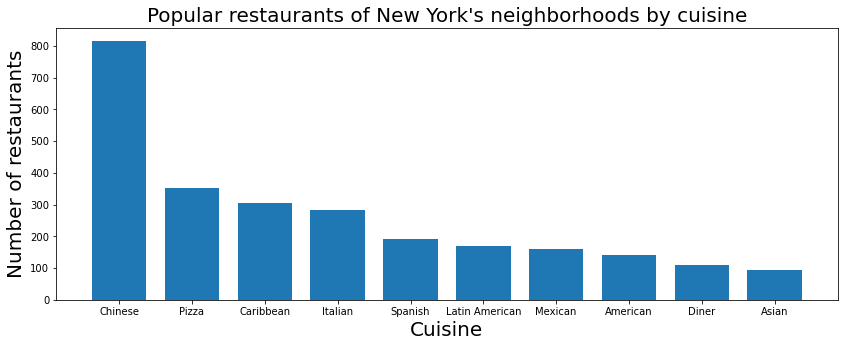

In [26]:
xpos=[4*x for x in range(10) ]
plt.figure(figsize=(14, 5))
plt.bar(xpos, nums,width=3)
plt.ylabel('Number of restaurants',fontsize=20)
plt.xlabel('Cuisine',fontsize=20)
plt.title("Popular restaurants of New York's neighborhoods by cuisine",fontsize=20)
plt.xticks(xpos,types)
plt.show()

Preparing the data for Kmeans clustering by grouping the data by neighborhood

In [27]:
onehotmean = onehot.groupby([ "neighborhood","borough","lat","lon" ]).mean().reset_index()

print(onehotmean.shape)
onehotmean.head()

(301, 138)


,neighborhood,borough,lat,lon,African,American,Arcade,Arepas,Art Gallery,Asian,...,Thai,Theater,Tibetan,Turkish,Ukrainian,Vegetarian / Vegan,Vietnamese,Wine Bar,Wings,Yemeni Restaurant
0,Allerton,Bronx,40.865788,-73.859319,0.0,0.05,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Annadale,Staten Island,40.538114,-74.178549,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Arden Heights,Staten Island,40.549286,-74.185887,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arlington,Staten Island,40.635325,-74.165104,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Arrochar,Staten Island,40.596313,-74.067124,0.0,0.00,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


This dataset is being prepared to help us visualize each neighbourbood's restaurants by their popular cuisine types

In [28]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = [ "neighborhood","borough","lat","lon" ]
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most common type of restaurant'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most common type of restaurant'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
datasorted=[]
datasorted = pd.DataFrame(columns=columns)
datasorted['neighborhood'] = onehotmean['neighborhood']
datasorted['borough'] = onehotmean['borough']
datasorted['lat'] = onehotmean['lat']
datasorted['lon'] = onehotmean['lon']
for ind in np.arange(onehotmean.shape[0]):
    row_categories = onehotmean.iloc[ind, :].iloc[4:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    datasorted.iloc[ind, 4:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(datasorted.shape)
datasorted.head()

(301, 14)


,neighborhood,borough,lat,lon,1st Most common type of restaurant,2nd Most common type of restaurant,3rd Most common type of restaurant,4th Most common type of restaurant,5th Most common type of restaurant,6th Most common type of restaurant,7th Most common type of restaurant,8th Most common type of restaurant,9th Most common type of restaurant,10th Most common type of restaurant
0,Allerton,Bronx,40.865788,-73.859319,Spanish,Unknown,Mexican,Chinese,Restaurant,Eastern European,Bakery,Caribbean,Racetrack,Design
1,Annadale,Staten Island,40.538114,-74.178549,Pizza,Sushi,Yemeni Restaurant,Ethiopian,Filipino,Fast Food,Falafel,Event Space,Event Services,Entertainment
2,Arden Heights,Staten Island,40.549286,-74.185887,Pizza,Chinese,Yemeni Restaurant,Ethiopian,Filipino,Fast Food,Falafel,Event Space,Event Services,Entertainment
3,Arlington,Staten Island,40.635325,-74.165104,Pizza,Chinese,Yemeni Restaurant,Ethiopian,Filipino,Fast Food,Falafel,Event Space,Event Services,Entertainment
4,Arrochar,Staten Island,40.596313,-74.067124,Italian,Chinese,Mediterranean,Event Services,Filipino,Fast Food,Falafel,Event Space,Ethiopian,Food & Drink


 Before clustering lets see the neighborhoods we are analysing.

In [18]:
geolocator = Nominatim(user_agent="NY")
location = geolocator.geocode("New York")
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York are 40.7127281, -74.0060152.


In [19]:


newmap = folium.Map(location=[latitude, longitude], zoom_start=11)
d=datasorted
print("The neighborhoods of New York whose data has been used")
# add markers to map
for lat, lng, borough, neighborhood in zip(d['lat'], d['lon'], d['borough'], d['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(newmap)  
    
newmap

The neighborhoods of New York whose data has been used


Now lets do the clustering.

In [29]:
clusterdata = onehotmean.drop(["neighborhood","borough","lat","lon"], 1)
kclusters = 6 #6 was chosen because it was the elbow part in the elbow test graph to chose the correct no of clusters.
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(clusterdata) 

The clustering is done. Now lets try to understand what each cluster is.

In [30]:
final = datasorted
final["cluster num"]=kmeans.labels_
for k in range(kclusters):
    print("cluster number: ",k)
    print(final["1st Most common type of restaurant"][final["cluster num"]==k].head(5))



cluster number:  0
0        Spanish
6        Italian
8         Korean
10       Chinese
11    Restaurant
Name: 1st Most common type of restaurant, dtype: object
cluster number:  1
32    Caribbean
35    Caribbean
36      Chinese
40      Unknown
41    Caribbean
Name: 1st Most common type of restaurant, dtype: object
cluster number:  2
15    Unknown
19    Unknown
25    Chinese
28    Unknown
43    Unknown
Name: 1st Most common type of restaurant, dtype: object
cluster number:  3
4     Italian
13    Italian
22    Italian
24    Italian
39    Italian
Name: 1st Most common type of restaurant, dtype: object
cluster number:  4
7     Chinese
9     Chinese
12    Chinese
14    Chinese
16    Chinese
Name: 1st Most common type of restaurant, dtype: object
cluster number:  5
1     Pizza
2     Pizza
3     Pizza
5     Pizza
85    Pizza
Name: 1st Most common type of restaurant, dtype: object


What defines each cluster can be identified from above output very easily:<br>
__Cluster type: Number__<br>
 Mix         :  0<br>
 Caribean     :  1<br>
 Unknown        :  2<br>
 Italian     :  3<br>
 Chinese     :  4<br>
 Pizza     :  5<br>

Lets plot the neighborhoods in the map again but with color based on their cluster type/cuisine to see any geographical insights.

In [31]:
newmap = folium.Map(location=[latitude, longitude], zoom_start=10.5)
d=final
colors=["Blue","Green","Red","White","Yellow","Black"]
labels=["Mix       ","Caribean  ","Unknown   ","Italian   ","Chinese   ","Pizza     "]
print("Cluster type: color")
for n in range(0,len(colors)):
    print(labels[n]," : ",colors[n])
# add markers to map
for lat, lng, borough, neighborhood,n in zip(d['lat'], d['lon'], d['borough'], d['neighborhood'],d["cluster num"]):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=colors[n],
        fill=True,
        fill_color=colors[n],
        fill_opacity=0.7,
        parse_html=False).add_to(newmap)  
    
newmap

Cluster type: color
Mix         :  Blue
Caribean    :  Green
Unknown     :  Red
Italian     :  White
Chinese     :  Yellow
Pizza       :  Black


It is evident from above map that the city can be somewhat be divided by area based on their most popular restaurants cuisines. 

Lets plot a bar graph to see the number of neighborhoods where the cuisines are the most popular.

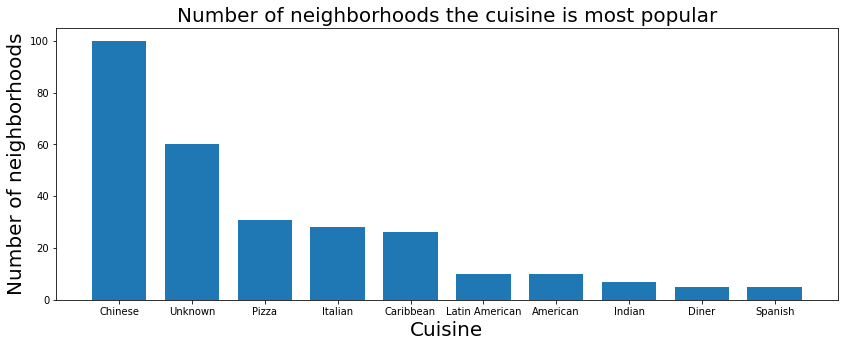

In [235]:
popular = pd.DataFrame(final[["1st Most common type of restaurant"]]).copy()
popular["count"]=1
popular = pd.DataFrame(popular.groupby(["1st Most common type of restaurant"],as_index=False)["count"].sum())
popular = popular.sort_values("count",ascending=False).reset_index()
del popular["index"]
types = popular["1st Most common type of restaurant"][:10].tolist()
nums= popular["count"][:10].tolist()
xpos=[4*x for x in range(10) ]
plt.figure(figsize=(14, 5))
plt.bar(xpos, nums,width=3)
plt.ylabel('Number of neighborhoods',fontsize=20)
plt.xlabel('Cuisine',fontsize=20)
plt.title("Number of neighborhoods the cuisine is most popular",fontsize=20)
plt.xticks(xpos,types)
plt.show()

Now for 2nd most popular.

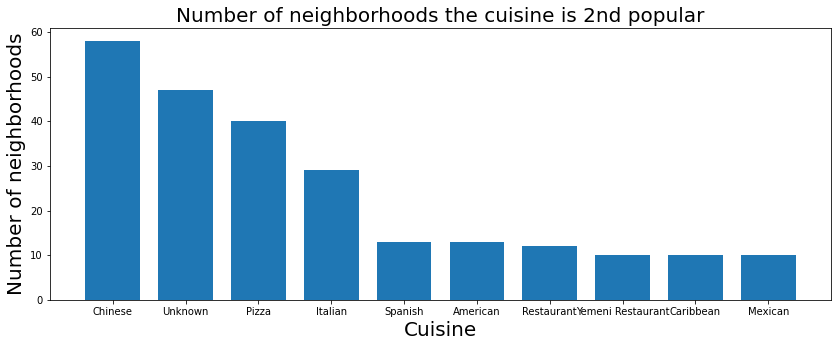

In [236]:
popular = pd.DataFrame(final[["2nd Most common type of restaurant"]]).copy()
popular["count"]=1
popular = pd.DataFrame(popular.groupby(["2nd Most common type of restaurant"],as_index=False)["count"].sum())
popular = popular.sort_values("count",ascending=False).reset_index()
del popular["index"]
types = popular["2nd Most common type of restaurant"][:10].tolist()
nums= popular["count"][:10].tolist()
xpos=[4*x for x in range(10) ]
plt.figure(figsize=(14, 5))
plt.bar(xpos, nums,width=3)
plt.ylabel('Number of neighborhoods',fontsize=20)
plt.xlabel('Cuisine',fontsize=20)
plt.title("Number of neighborhoods the cuisine is 2nd popular",fontsize=20)
plt.xticks(xpos,types)
plt.show()

And for 3rd most popular

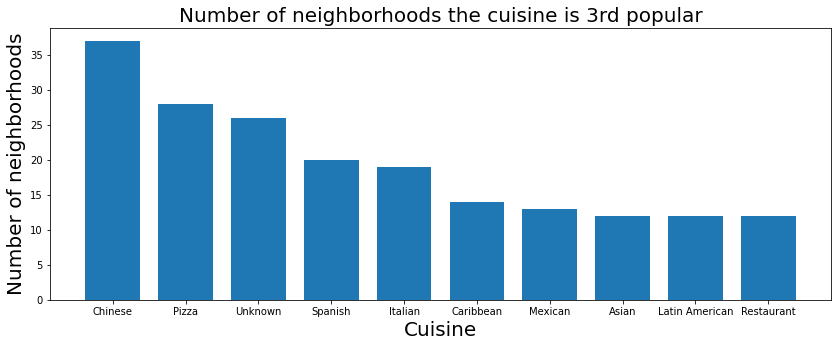

In [237]:
popular = pd.DataFrame(final[["3rd Most common type of restaurant"]]).copy()
popular["count"]=1
popular = pd.DataFrame(popular.groupby(["3rd Most common type of restaurant"],as_index=False)["count"].sum())
popular = popular.sort_values("count",ascending=False).reset_index()
del popular["index"]
types = popular["3rd Most common type of restaurant"][:10].tolist()
nums= popular["count"][:10].tolist()
xpos=[4*x for x in range(10) ]
plt.figure(figsize=(14, 5))
plt.bar(xpos, nums,width=3)
plt.ylabel('Number of neighborhoods',fontsize=20)
plt.xlabel('Cuisine',fontsize=20)
plt.title("Number of neighborhoods the cuisine is 3rd popular",fontsize=20)
plt.xticks(xpos,types)
plt.show()